In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras.models import Model
from Load_model import CNN_Net

RuntimeError: Error(s) in loading state_dict for CNN_Net:
	Missing key(s) in state_dict: "model.12.weight", "model.12.bias", "model.14.weight", "model.14.bias". 
	Unexpected key(s) in state_dict: "model.16.weight", "model.16.bias", "model.13.weight", "model.13.bias". 

In [8]:
# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_state_dict = torch.load('mnist_cnn_model.pth', map_location=device)

# Get all parameters
params = list(model_state_dict.items())
n_params = len(params)

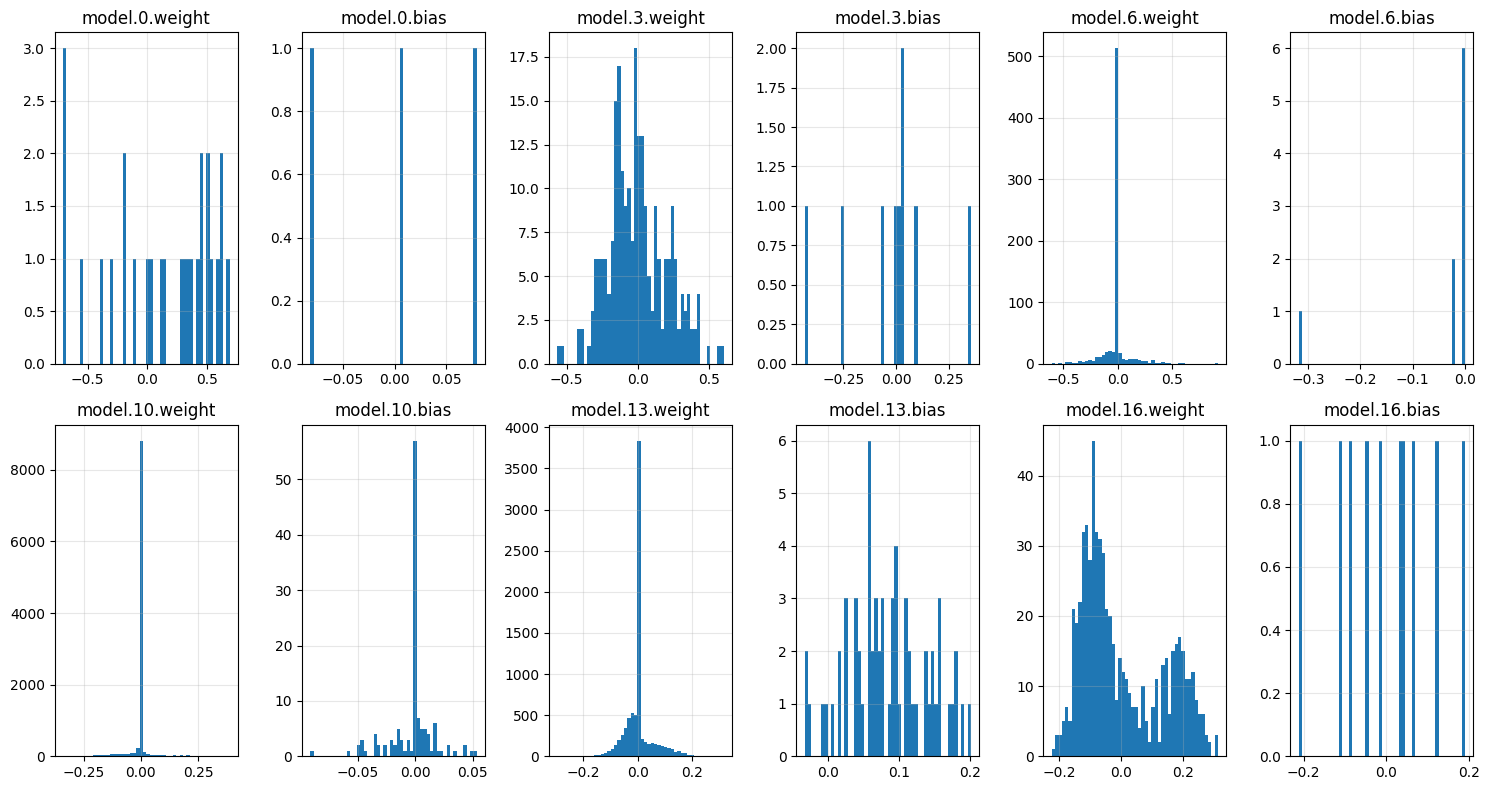

In [9]:
# Create subplots
fig, axes = plt.subplots(2, (n_params + 1) // 2, figsize=(15, 8))
axes = axes.flatten() if n_params > 1 else [axes]

# Plot each parameter
for i, (name, tensor) in enumerate(params):
    values = tensor.cpu().numpy().flatten()
    axes[i].hist(values, bins=50)
    axes[i].set_title(name)
    axes[i].grid(True, alpha=0.3)


plt.tight_layout()
plt.show()


In [ ]:
layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name or 'pool' in layer.name] 